In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import trimesh
from trimesh import Scene

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


I got raytracing working I need to be able to move around the object though...

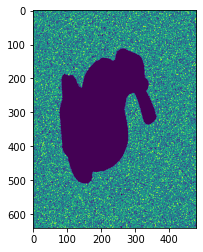

In [2]:

# test on a sphere mesh
mesh = trimesh.primitives.Sphere()

mesh = trimesh.load("../models/bunny.ply")

# Normalize the mesh using trimesh functionality
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)



def raytrace_silhouette(mesh, perc=0.5):

    # scene will have automatically generated camera and lights
    scene: Scene = mesh.scene()

    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    msk = np.random.rand(*scene.camera.resolution) < perc

    # convert the camera to rays with one ray per pixel
    origin, vectors, pixels = scene.camera_rays()

    # run the mesh- ray test
    points, index_ray, index_tri = mesh.ray.intersects_location(
        ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
    )

    # find pixel locations of actual hits
    sub_pixels = pixels[msk.flat]
    pixel_ray = sub_pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

sil = raytrace_silhouette(mesh)
plt.imshow(sil == 1)


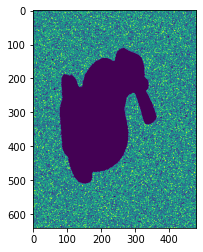

In [3]:

sil = raytrace_silhouette(mesh)
plt.imshow(sil == 1)

In [4]:
%%timeit
sil = raytrace_silhouette(mesh)

130 ms ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


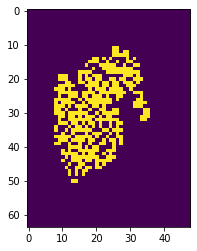

In [5]:

# scene will have automatically generated camera and lights
scene: Scene = mesh.scene()

# any of the automatically generated values can be overridden
# set resolution, in pixels
scene.camera.resolution = [64, 48]
# set field of view, in degrees
# make it relative to resolution so pixels per degree is same
scene.camera.fov = [
    60,
    60,
]  # * (scene.camera.resolution / scene.camera.resolution.max())
msk = np.random.rand(*scene.camera.resolution) < 0.6

# convert the camera to rays with one ray per pixel
origin, vectors, pixels = scene.camera_rays()  # this takes ~ 20 ms and can be cached

# run the mesh- ray test
points, index_ray, index_tri = mesh.ray.intersects_location(
    ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
)

# find pixel locations of actual hits
pixel_ray = pixels[msk.flat][index_ray]

# create a numpy array we can turn into an image
# doing it with uint8 creates an `L` mode greyscale image
a = np.zeros(scene.camera.resolution, dtype=np.uint8)
a[pixels[msk.flat, 0], pixels[msk.flat, 1]] = 1
a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
plt.imshow(a == 2)

In [6]:
%%timeit
# convert the camera to rays with one ray per pixel
# origin, vectors, pixels = scene.camera_rays()
points, index_ray, index_tri = mesh.ray.intersects_location(
    ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
)

1.01 ms ± 90.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
vectors

array([[-0.44344089,  0.44109464, -0.78025361],
       [-0.44707844,  0.425789  , -0.78665405],
       [-0.45064296,  0.41010893, -0.79292597],
       ...,
       [ 0.45064296, -0.41010893, -0.79292597],
       [ 0.44707844, -0.425789  , -0.78665405],
       [ 0.44344089, -0.44109464, -0.78025361]])

So I can cache the scene rays, I can also eventually experiment with something else...

I/U is == count of points in mask / total count of points? 

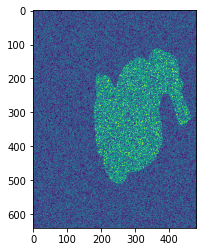

In [8]:
plt.imshow(np.roll(sil, 100))

In [9]:
## jacaards index for comparing two incomplete masks:
def stochastic_jacaard_index(m1: np.ndarray, m2: np.ndarray):
    """Where 2 means positive, 1 means negative, and 0 means not measured/unknown, I / U should only consider knowns"""
    m1_pos = m1 == 2
    m2_pos = m2 == 2
    m1_neg = m1 == 1
    m2_neg = m2 == 1
    count_agree_pos = (m1_pos & m2_pos).sum()  # intersection
    count_pos = (m1_pos & m2_neg).sum() + (m1_neg & m2_pos).sum() + count_agree_pos
    if count_pos == 0:
        return 0
    return count_agree_pos / count_pos
stochastic_jacaard_index(sil, sil)

1.0

0.5039103690685413

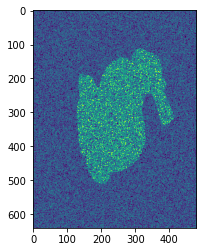

In [10]:
plt.imshow(np.roll(sil, 50))
stochastic_jacaard_index(sil, np.roll(sil, 50))

So now lets try doing transformations so I can determine the object position and orientation

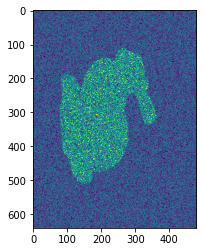

In [11]:

rotation_angles = [0, 0, 0] # No rotation
translation_vector = [0, 0, 5] # Translate bunny along z-axis to be in view

# Create new transformation matrix
rotation_matrix = trimesh.transformations.euler_matrix(
    np.radians(rotation_angles[0]), 
    np.radians(rotation_angles[1]), 
    np.radians(rotation_angles[2])
)
transformation_matrix = rotation_matrix.copy()
transformation_matrix[:3, 3] = translation_vector

transformed = mesh.copy()
# Apply the transformation to the bunny mesh
transformed.apply_transform(transformation_matrix)

plt.imshow(raytrace_silhouette(transformed))

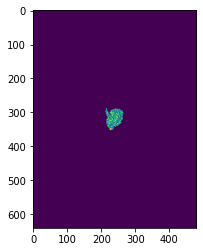

In [12]:

rotation_angles = [30, 0, 0] # No rotation
translation_vector = [0, 0, -2] # Translate bunny along z-axis to be in view

mesh = trimesh.load_mesh("../models/bunny.ply", force="mesh")
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)
mesh.apply_transform(trimesh.transformations.random_rotation_matrix())
tt = mesh.apply_obb()  # i guess it works..

# Create new transformation matrix
rotation_matrix = trimesh.transformations.euler_matrix(
    np.radians(rotation_angles[0]), 
    np.radians(rotation_angles[1]), 
    np.radians(rotation_angles[2]), axes="rxyz"
)

quaternion = np.array([0.8, 0.3, 0, 0])
quaternion = quaternion / np.linalg.norm(quaternion)
rotation_matrix = trimesh.transformations.quaternion_matrix(quaternion)
transformation_matrix = rotation_matrix.copy()
# transformation_matrix[:3, 3] = translation_vector

# transformation_matrix = trimesh.transformations.rotation_matrix(30, [1, 1, 0], [0, 0, 0])
transformation_matrix = trimesh.transformations.random_rotation_matrix()
#transformation_matrix = trimesh.transformations.translation_matrix([0, 0, 2])

transformed = mesh.copy()
# scene will have automatically generated camera and lights
scene = Scene()
scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)

scene.apply_translation([0, 0, 5])

# scene.apply_transform(transformation_matrix)
# scene.geometry["mesh"].apply_transform(transformation_matrix)
#scene.geometry["mesh"].apply_transform(trimesh.transformations.random_rotation_matrix())
# scene: Scene = mesh.scene()

# any of the automatically generated values can be overridden
# set resolution, in pixels
scene.camera.resolution = [640, 480]
# set field of view, in degrees
# make it relative to resolution so pixels per degree is same
scene.camera.fov = [
    60,
    60,
]  # * (scene.camera.resolution / scene.camera.resolution.max())
msk = np.random.rand(*scene.camera.resolution) < 0.6

# convert the camera to rays with one ray per pixel
origin, vectors, pixels = scene.camera_rays()  # this takes ~ 20 ms and can be cached

# run the mesh- ray test
points, index_ray, index_tri = mesh.ray.intersects_location(
    ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
)

# find pixel locations of actual hits
pixel_ray = pixels[msk.flat][index_ray]

# create a numpy array we can turn into an image
# doing it with uint8 creates an `L` mode greyscale image
a = np.zeros(scene.camera.resolution, dtype=np.uint8)
a[pixels[msk.flat, 0], pixels[msk.flat, 1]] = 1
a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
plt.imshow(a == 2)

In [13]:
scene.geometry["mesh"]

<trimesh.Trimesh(vertices.shape=(8146, 3), faces.shape=(16301, 3))>

In [14]:
trimesh.transformations.rotation_from_matrix(transformation_matrix)

(2.199742861462258,
 array([-0.02839792, -0.49920984,  0.86601564]),
 array([0., 0., 0., 1.]))

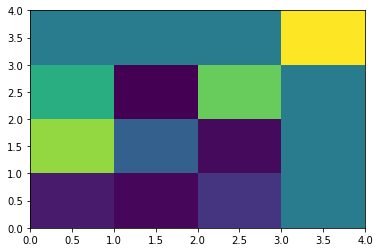

In [15]:
plt.pcolormesh(transformation_matrix)

In [16]:
trimesh.transformations.random_rotation_matrix()

array([[-0.69435402, -0.57316029,  0.43515489,  0.        ],
       [-0.66399065,  0.27711561, -0.69449504,  0.        ],
       [ 0.27746877, -0.7711642 , -0.57298941,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Taking the cell above, I'm determining I first scale, center, scale, and transform, then apply_obb() then I translate the scene (?)

Clean up, and determine bounds

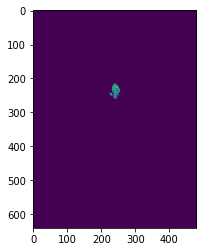

In [96]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)

    scene.apply_translation(translation_vector)
    return scene


def raytrace_silhouette(scene: Scene, perc=0.5):
    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    msk = np.random.rand(*scene.camera.resolution) < perc

    # convert the camera to rays with one ray per pixel
    origin, vectors, pixels = scene.camera_rays()

    # run the mesh- ray test
    points, index_ray, index_tri = scene.geometry["mesh"].ray.intersects_location(
        ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
    )

    # find pixel locations of actual hits
    sub_pixels = pixels[msk.flat]
    pixel_ray = sub_pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a


translation_vector = [0, 0, -2] # Translate bunny along z-axis to be in view

mesh = trimesh.load_mesh("../models/bunny.ply", force="mesh")
# normalize it
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)

scene = get_transformed_scene(mesh, trimesh.transformations.random_rotation_matrix(), [2, 0, 12])

sil = raytrace_silhouette(scene)
plt.imshow(sil == 2)

In [ ]:
o, v, p = scene.camera_rays()

In [97]:
fig, ax = plt.subplots()

rotation = np.random.rand(3) * 2 * np.pi
translation = [0, 0, 3]

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)

sil = raytrace_silhouette(scene)

img = ax.imshow(sil == 2)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    global rotation, translation
    rotation[1] += 0.1
    rotation = rotation % (np.pi * 2)
    translation[1] = (translation[1] + 0.1) % 2
    translation[2] = (translation[2] + 0.1) % 2
    scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)

    sil = raytrace_silhouette(scene, 0.5)
    img.set_data(sil == 2)
    return img

ani = FuncAnimation(fig, update, frames=range(50), blit=False, interval=100)
HTML(ani.to_jshtml())

Now I have something that translates and rotates...

Still have some unanswered questions there, but its at least 'kind of' continuous

I want to now create a test mask to compare it to - this will be generated as the mesh at a preset random translation/rotation
Then I want to use optimization with stochastic jacaards index to align them when there is a slight perturbation

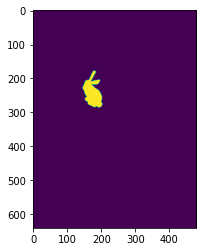

In [19]:

true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, 1)

plt.imshow(true_sil == 2)

1.0


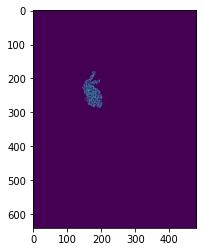

In [20]:
test_sil = raytrace_silhouette(scene, .25)
print(stochastic_jacaard_index(test_sil, true_sil))
plt.imshow(test_sil == 2)

0.04599270584430751


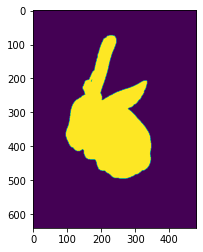

In [92]:

rotation = true_rotation + np.array([.2, .1, .2])
translation = true_translation + np.array([.3, 0.2, 1])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, 1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow((sil == 2) + (true_sil == 2))

0.04225352112676056


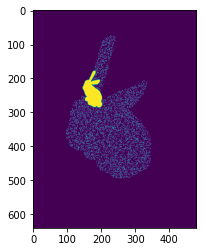

In [90]:

sil = raytrace_silhouette(scene, .1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow((sil == 2) + (true_sil == 2))

(array([ 4.,  5., 13., 20., 19., 23., 13.,  2.,  0.,  1.]),
 array([0.15909091, 0.16694419, 0.17479748, 0.18265077, 0.19050405,
        0.19835734, 0.20621062, 0.21406391, 0.22191719, 0.22977048,
        0.23762376]),
 <BarContainer object of 10 artists>)

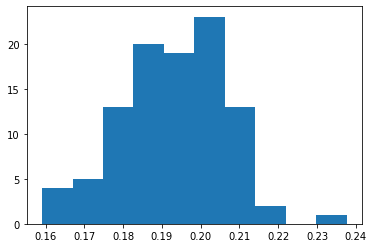

In [23]:
scores = []
for i in range(100):
    sil = raytrace_silhouette(scene, .1)
    scores.append(stochastic_jacaard_index(true_sil, sil))

plt.hist(scores)

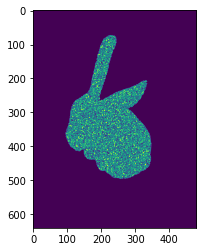

In [54]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    transformed.apply_translation(translation_vector)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    return scene


def raytrace_silhouette_precomputed(scene: Scene, origin, vectors, pixels, perc=0.5):
    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    msk = np.random.rand(*scene.camera.resolution) < perc

    # run the mesh- ray test
    points, index_ray, index_tri = scene.geometry["mesh"].ray.intersects_location(
        ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
    )

    # find pixel locations of actual hits
    sub_pixels = pixels[msk.flat]
    pixel_ray = sub_pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

# the problem is that the rays are computed before translation...
scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)

# convert the camera to rays with one ray per pixel
origin, vectors, pixels = scene.camera_rays()

sil = raytrace_silhouette_precomputed(scene, origin, vectors, pixels)

plt.imshow(sil == 2)

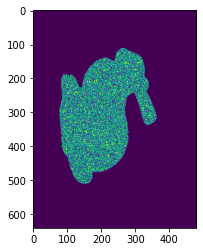

In [66]:
scene = Scene()

scene.add_geometry(mesh, geom_name="mesh")
scene.camera.resolution = [640, 480]
# set field of view, in degrees
# make it relative to resolution so pixels per degree is same
scene.camera.fov = [
    60,
    60,
]  # * (scene.camera.resolution / scene.camera.resolution.max())

origin0, vectors0, pixels0 = scene.camera_rays()


sil = raytrace_silhouette_precomputed(scene, origin0, vectors0, pixels0)

plt.imshow(sil == 2)

In [73]:
mesh.centroid

array([1.74889280e-16, 8.45854242e-16, 2.01753868e-16])

In [76]:
get_transformed_scene(mesh, trimesh.transformations.random_rotation_matrix(), [0, 0, 0]).camera_transform

array([[ 1.        ,  0.        ,  0.        ,  0.0311124 ],
       [ 0.        ,  1.        ,  0.        ,  0.02098843],
       [-0.        ,  0.        ,  1.        ,  1.55711296],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [86]:
%%timeit
np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), vectors0.shape)

6.99 µs ± 570 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


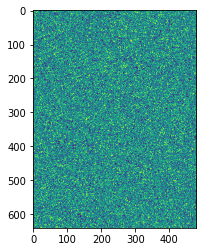

In [55]:

# the problem is that the rays are computed before translation...
test_translation = np.array(translation)
test_translation[2] -= 1
test_translation[1] -= 1
test_translation[0] -= 1

test_rotation = np.array(rotation)
test_rotation[2] += .5

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*test_rotation), test_translation)

# convert the camera to rays with one ray per pixel
origin2, vectors2, pixels2 = scene.camera_rays()

sil = raytrace_silhouette_precomputed(scene, origin, vectors, pixels)

plt.imshow(sil == 0)

In [61]:
(pixels != pixels2).sum()

0

In [28]:
%%timeit
sil = raytrace_silhouette_precomputed(scene, origin, vectors, pixels, 0.05)

15.3 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


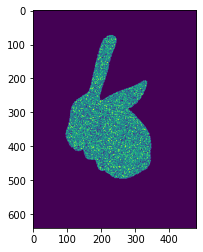

In [87]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    transformed.apply_translation(translation_vector)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    return scene


def raytrace_silhouette_precomputed(scene: Scene, vectors, pixels, perc=0.5):
    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    msk = np.random.rand(*scene.camera.resolution) < perc

    origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), vectors.shape)

    # run the mesh- ray test
    points, index_ray, index_tri = scene.geometry["mesh"].ray.intersects_location(
        ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
    )

    # find pixel locations of actual hits
    sub_pixels = pixels[msk.flat]
    pixel_ray = sub_pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

# the problem is that the rays are computed before translation...
scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)

# convert the camera to rays with one ray per pixel
origin, vectors, pixels = scene.camera_rays()

sil = raytrace_silhouette_precomputed(scene, vectors, pixels)

plt.imshow(sil == 2)

In [89]:
%%timeit
sil = raytrace_silhouette_precomputed(scene, vectors, pixels, 0.1)

17.3 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
